In [1]:
# IMPORT LIBRARIES

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
import warnings
warnings.filterwarnings('ignore')

- Pregnancies:  Hamilelik sayısı
- Glucose Oral: glikoz tolerans testinde 2 saatlik plazma glikoz konsantrasyonu
- Blood Pressure: Kan Basıncı (Küçük tansiyon) (mm Hg)
- SkinThickness: Cilt Kalınlığı
- Insulin: 2 saatlik serum insülini (mu U/ml)
- DiabetesPedigreeFunction: Fonksiyon (Oral glikoz tolerans testinde 2 saatlik plazma glikoz konsantrasyonu)
- BMI: Vücut kitle endeksi
- Age: Yaş (yıl)
- Outcome: Hastalığa sahip (1) ya da değil (0)

In [2]:
df = pd.read_csv("datasets\diabetes.csv")

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
#Shape 
df.shape

(768, 9)

In [5]:
#Check missing values
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
# Quantiles
df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T

,0.00,0.05,0.50,0.95,0.99,1.00
Pregnancies,0.000,0.00000,3.0000,10.00000,13.00000,17.00
Glucose,0.000,79.00000,117.0000,181.00000,196.00000,199.00
BloodPressure,0.000,38.70000,72.0000,90.00000,106.00000,122.00
SkinThickness,0.000,0.00000,23.0000,44.00000,51.33000,99.00
Insulin,0.000,0.00000,30.5000,293.00000,519.90000,846.00
BMI,0.000,21.80000,32.0000,44.39500,50.75900,67.10
DiabetesPedigreeFunction,0.078,0.14035,0.3725,1.13285,1.69833,2.42
Age,21.000,21.00000,29.0000,58.00000,67.00000,81.00
Outcome,0.000,0.00000,0.0000,1.00000,1.00000,1.00


## Check Columns (Categorical or Numeric)

In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    It gives the names of categorical, numerical, and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
        cat_th: int, optional
                the class threshold for numeric but categorical variables
        car_th: int, optinal
                the class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical Variables List
        num_cols: list
                Numeric Variables List
        cat_but_car: list
                Categorical but cardinal variables list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is in cat_cols

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [8]:
cat_cols

['Outcome']

   Outcome      Ratio
0      500  65.104167
1      268  34.895833


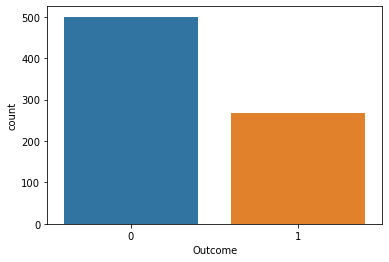

In [9]:
# SUMMARY CATEGORICAL COLUMNS
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for i in cat_cols:
    cat_summary(df, i, plot=True)


In [10]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [11]:
# SUMMARY NUMERİC COLUMNS
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")


count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64


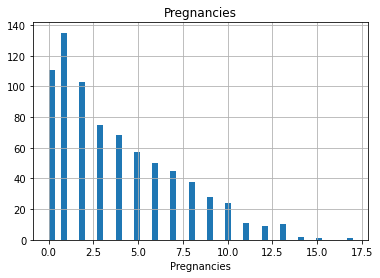

#####################################
count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64


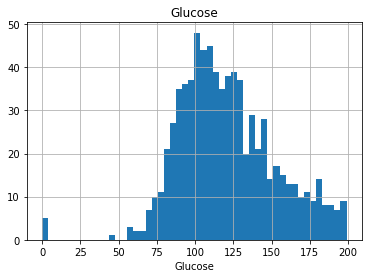

#####################################
count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64


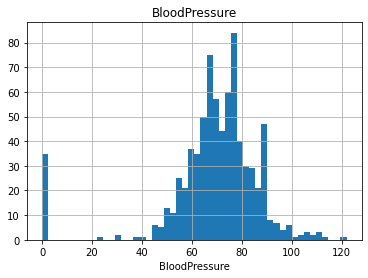

#####################################
count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        8.200000
40%       18.000000
50%       23.000000
60%       27.000000
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SkinThickness, dtype: float64


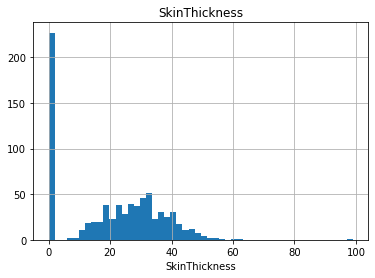

#####################################
count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: Insulin, dtype: float64


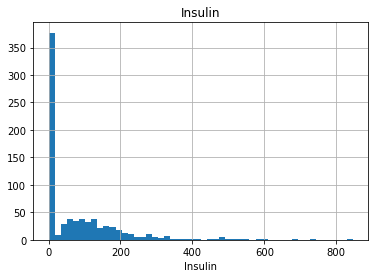

#####################################
count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


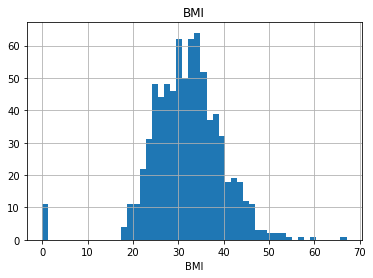

#####################################
count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


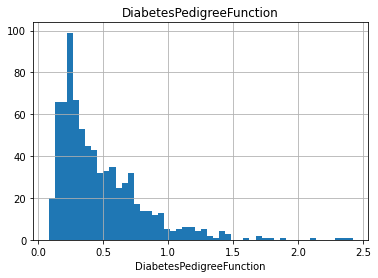

#####################################
count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64


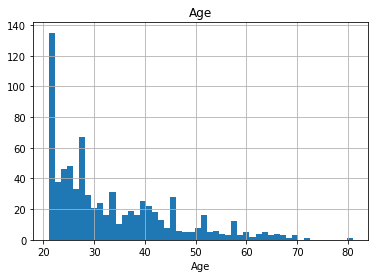

#####################################


In [12]:
for col in num_cols:
    num_summary(df, col, plot=True)

In [13]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


In [14]:
for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




# DATA PREPROCESSING

## OUTLIERS

In [15]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [16]:
for col in num_cols:
    print(f"{col} : {check_outlier(df,col)}")

Pregnancies : True
Glucose : True
BloodPressure : True
SkinThickness : True
Insulin : True
BMI : True
DiabetesPedigreeFunction : True
Age : True


In [17]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [18]:
for col in num_cols:
    col, grab_outliers(df, col)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
88            15      136             70             32      110  37.1   
159           17      163             72             41      114  40.9   
298           14      100             78             25      184  36.6   
455           14      175             62             30        0  33.6   

     DiabetesPedigreeFunction  Age  Outcome  
88                      0.153   43        1  
159                     0.817   47        1  
298                     0.412   46        1  
455                     0.212   38        1  
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
75             1        0             48             20        0  24.7   
182            1        0             74             20       23  27.7   
342            1        0             68             35        0  32.0   
349            5        0             80             32        0  41.0   
502            6        0    

In [19]:
threshold = grab_outliers(df, col)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
123            5      132             80              0        0  26.8   
363            4      146             78              0        0  38.5   
453            2      119              0              0        0  19.6   
459            9      134             74             33       60  25.9   
489            8      194             80              0        0  26.1   
537            0       57             60              0        0  21.7   
666            4      145             82             18        0  32.5   
674            8       91             82              0        0  35.6   
684            5      136             82              0        0   0.0   

     DiabetesPedigreeFunction  Age  Outcome  
123                     0.186   69        0  
363                     0.520   67        1  
453                     0.832   72        0  
459                     0.460   81        0  
489                     0.551

In [20]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [21]:
for col in num_cols:
    replace_with_thresholds(df, col)

## MISSING VALUES

In [22]:
zero_columns = [i for i in df.columns if (df[i].min() == 0 and i not in ["Pregnancies", "Outcome"])]

for i in zero_columns:
    df[[i]] = df[[i]].replace(0, np.NaN)

df.isnull().sum()

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head()


imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,244.45,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,56.20,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,32.2,222.45,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.00,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.00,43.1,1.200,33.0,1.0


In [23]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## CORRELATION ANALYSIS

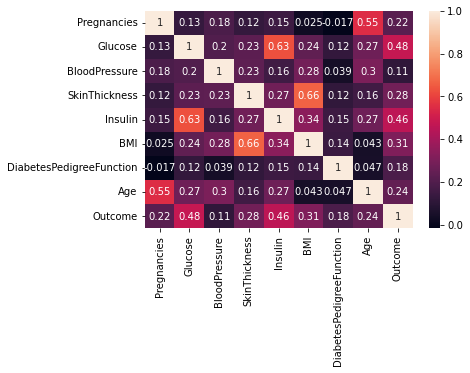

,1,2,corr
33,Age,Pregnancies,0.719707
34,Glucose,Insulin,0.781214
35,SkinThickness,BMI,0.827103
36,Pregnancies,Pregnancies,1.000000


In [24]:
df.corrwith(df["Outcome"]).sort_values(ascending=False)
corr_df = df.corr()

sns.heatmap(corr_df, annot=True, xticklabels=corr_df.columns, yticklabels=corr_df.columns)
plt.show()

corr_df = corr_df.corr().unstack().sort_values().drop_duplicates()
corr_df = pd.DataFrame(corr_df, columns=["corr"])
corr_df.index.names = ['1', '2']
corr_df = corr_df.reset_index()
corr_df.sort_values(by="corr", ascending=True).head(30)

high_corr = corr_df[(corr_df["corr"] >= 0.70) | (corr_df["corr"] <= -0.70)]
high_corr

## FEATURE ENGINEERING

In [25]:
df["glucose_age_ratio"] = df["Glucose"]/df["Age"]

In [26]:
df["insulin_age_ratio"] = df["Insulin"]/df["Age"]

In [27]:
df["insulin_glucose_ratio"] = df["Insulin"]/df["Glucose"]

In [28]:
df["skinthickness_age_ratio"] = df["SkinThickness"]/df["Age"]

In [29]:
df["skinthickness_insulin_ratio"] = df["SkinThickness"]/df["Insulin"]

In [30]:
df["skinthickness_pregnancies_ratio"] = df["Pregnancies"]/df["SkinThickness"]

In [31]:
def set_bmi(row):
    if row['BMI'] < 18.5:
        return "Under"
    elif row['BMI'] >= 18.5 and row['BMI'] <=24.9:
        return "Healthy"
    elif row['BMI'] >= 25 and row['BMI'] <=29.9:
        return "Over"
    elif row["BMI"] >= 30:
        return "Obese"

In [32]:
df = df.assign(BM_DESC=df.apply(set_bmi, axis=1))
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,glucose_age_ratio,insulin_age_ratio,insulin_glucose_ratio,skinthickness_age_ratio,skinthickness_insulin_ratio,skinthickness_pregnancies_ratio,BM_DESC
0,6.0,148.0,72.0,35.0,244.45,33.6,0.627,50.0,1.0,2.960000,4.889000,1.651689,0.700000,0.143179,0.171429,Obese
1,1.0,85.0,66.0,29.0,56.20,26.6,0.351,31.0,0.0,2.741935,1.812903,0.661176,0.935484,0.516014,0.034483,Over
2,8.0,183.0,64.0,32.2,222.45,23.3,0.672,32.0,1.0,5.718750,6.951563,1.215574,1.006250,0.144752,0.248447,Healthy
3,1.0,89.0,66.0,23.0,94.00,28.1,0.167,21.0,0.0,4.238095,4.476190,1.056180,1.095238,0.244681,0.043478,Over
4,0.0,137.0,40.0,35.0,168.00,43.1,1.200,33.0,1.0,4.151515,5.090909,1.226277,1.060606,0.208333,0.000000,Obese


In [33]:
def set_insulin(row):
    if row['Insulin'] >= 16 and row['Insulin'] <=166:
        return "Normal"
    else:
        return "Abnormal"

In [34]:
df = df.assign(INSULIN_DESC=df.apply(set_insulin, axis=1))
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,glucose_age_ratio,insulin_age_ratio,insulin_glucose_ratio,skinthickness_age_ratio,skinthickness_insulin_ratio,skinthickness_pregnancies_ratio,BM_DESC,INSULIN_DESC
0,6.0,148.0,72.0,35.0,244.45,33.6,0.627,50.0,1.0,2.960000,4.889000,1.651689,0.700000,0.143179,0.171429,Obese,Abnormal
1,1.0,85.0,66.0,29.0,56.20,26.6,0.351,31.0,0.0,2.741935,1.812903,0.661176,0.935484,0.516014,0.034483,Over,Normal
2,8.0,183.0,64.0,32.2,222.45,23.3,0.672,32.0,1.0,5.718750,6.951563,1.215574,1.006250,0.144752,0.248447,Healthy,Abnormal
3,1.0,89.0,66.0,23.0,94.00,28.1,0.167,21.0,0.0,4.238095,4.476190,1.056180,1.095238,0.244681,0.043478,Over,Normal
4,0.0,137.0,40.0,35.0,168.00,43.1,1.200,33.0,1.0,4.151515,5.090909,1.226277,1.060606,0.208333,0.000000,Obese,Abnormal


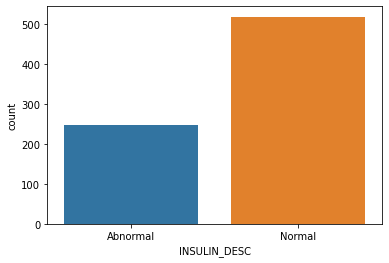

Number of patients Having Abnormal Insulin Levels:  519
Number of patients Having Normal Insulin Levels:  249


In [35]:
sns.countplot(data=df, x='INSULIN_DESC', label='Count')
plt.show()
AB, NB = df['INSULIN_DESC'].value_counts()
print('Number of patients Having Abnormal Insulin Levels: ',AB)
print('Number of patients Having Normal Insulin Levels: ',NB)

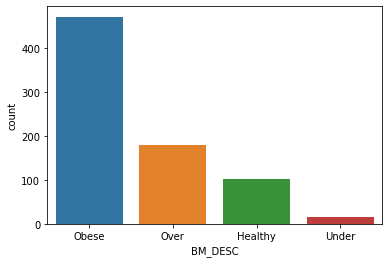

Number of patients Having Underweight BMI Index:  472
Number of patients Having Healthy BMI Index:  179
Number of patients Having Overweight BMI Index:  102
Number of patients Having Obese BMI Index:  15


In [36]:
sns.countplot(data=df, x = 'BM_DESC', label='Count')
plt.show()
UD,H,OV,OB = df['BM_DESC'].value_counts()
print('Number of patients Having Underweight BMI Index: ',UD)
print('Number of patients Having Healthy BMI Index: ',H)
print('Number of patients Having Overweight BMI Index: ',OV)
print('Number of patients Having Obese BMI Index: ',OB)

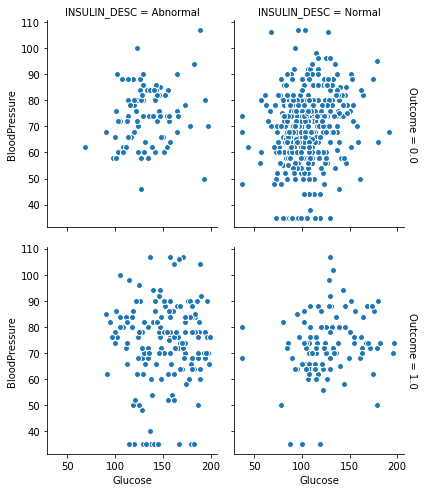

In [37]:
g = sns.FacetGrid(df, col='INSULIN_DESC', row='Outcome', margin_titles=True)
g.map(plt.scatter,"Glucose","BloodPressure", edgecolor='w')
plt.subplots_adjust(top=1.1)
plt.show()

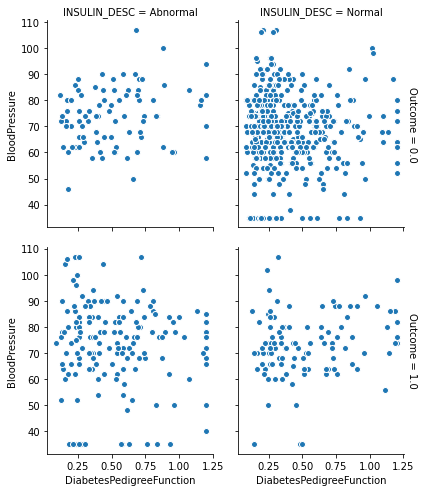

In [38]:
g = sns.FacetGrid(df, col='INSULIN_DESC', row='Outcome', margin_titles=True)
g.map(plt.scatter,"DiabetesPedigreeFunction","BloodPressure", edgecolor='w')
plt.subplots_adjust(top=1.1)
plt.show()

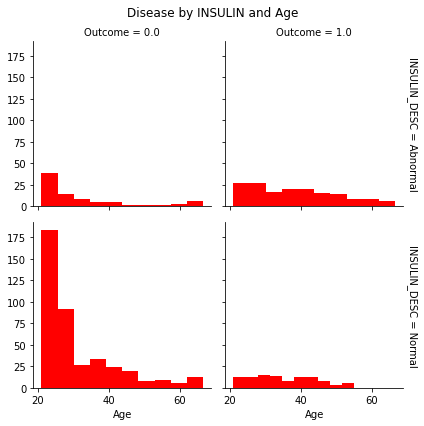

In [39]:
g = sns.FacetGrid(df, col='Outcome', row='INSULIN_DESC', margin_titles=True)
g.map(plt.hist, "Age", color='red')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Disease by INSULIN and Age');
plt.show()

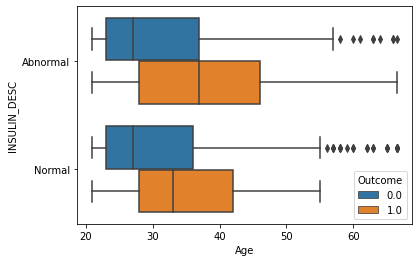

In [40]:
sns.boxplot(x='Age', y='INSULIN_DESC', hue='Outcome', data=df);
plt.show()

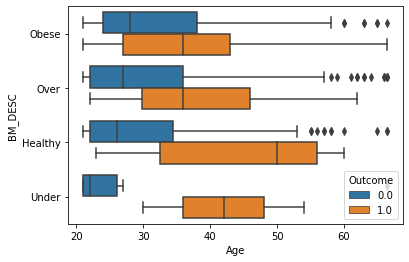

In [41]:
sns.boxplot(x='Age', y='BM_DESC', hue='Outcome', data=df);
plt.show()

In [42]:
df = pd.get_dummies(df, drop_first = True)

In [43]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 19
cat_cols: 5
num_cols: 14
cat_but_car: 0
num_but_cat: 5


In [44]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [45]:
df[num_cols].head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,glucose_age_ratio,insulin_age_ratio,insulin_glucose_ratio,skinthickness_age_ratio,skinthickness_insulin_ratio,skinthickness_pregnancies_ratio
0,0.647150,0.861926,0.092691,0.634514,1.447693,0.209359,0.588927,1.445691,-0.738863,0.121026,1.037129,-0.641495,-0.502557,0.230044
1,-0.848970,-1.159433,-0.330201,-0.006089,-1.236080,-0.784254,-0.378101,-0.189304,-0.900305,-1.086563,-1.073322,-0.038410,1.083420,-0.801439
2,1.245598,1.984903,-0.471166,0.335566,1.134051,-1.252672,0.746595,-0.103252,1.303551,0.930731,0.107913,0.142826,-0.495865,0.810152
3,-0.848970,-1.031093,-0.330201,-0.646692,-0.697187,-0.571337,-1.022787,-1.049828,0.207362,-0.041031,-0.231702,0.370728,-0.070784,-0.733684
4,-1.148194,0.508990,-2.162737,0.634514,0.357789,1.557835,2.596563,-0.017199,0.143264,0.200290,0.130719,0.282034,-0.225400,-1.061165


In [46]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,glucose_age_ratio,insulin_age_ratio,insulin_glucose_ratio,skinthickness_age_ratio,skinthickness_insulin_ratio,skinthickness_pregnancies_ratio,BM_DESC_Obese,BM_DESC_Over,BM_DESC_Under,INSULIN_DESC_Normal
0,0.647150,0.861926,0.092691,0.634514,1.447693,0.209359,0.588927,1.445691,1.0,-0.738863,0.121026,1.037129,-0.641495,-0.502557,0.230044,1,0,0,0
1,-0.848970,-1.159433,-0.330201,-0.006089,-1.236080,-0.784254,-0.378101,-0.189304,0.0,-0.900305,-1.086563,-1.073322,-0.038410,1.083420,-0.801439,0,1,0,1
2,1.245598,1.984903,-0.471166,0.335566,1.134051,-1.252672,0.746595,-0.103252,1.0,1.303551,0.930731,0.107913,0.142826,-0.495865,0.810152,0,0,0,0
3,-0.848970,-1.031093,-0.330201,-0.646692,-0.697187,-0.571337,-1.022787,-1.049828,0.0,0.207362,-0.041031,-0.231702,0.370728,-0.070784,-0.733684,0,1,0,1
4,-1.148194,0.508990,-2.162737,0.634514,0.357789,1.557835,2.596563,-0.017199,1.0,0.143264,0.200290,0.130719,0.282034,-0.225400,-1.061165,1,0,0,0


In [47]:
y = df["Outcome"]
X = df.drop(["Outcome", "BM_DESC_Under"], axis=1)

In [48]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,glucose_age_ratio,insulin_age_ratio,insulin_glucose_ratio,skinthickness_age_ratio,skinthickness_insulin_ratio,skinthickness_pregnancies_ratio,BM_DESC_Obese,BM_DESC_Over,INSULIN_DESC_Normal
0,0.647150,0.861926,0.092691,0.634514,1.447693,0.209359,0.588927,1.445691,-0.738863,0.121026,1.037129,-0.641495,-0.502557,0.230044,1,0,0
1,-0.848970,-1.159433,-0.330201,-0.006089,-1.236080,-0.784254,-0.378101,-0.189304,-0.900305,-1.086563,-1.073322,-0.038410,1.083420,-0.801439,0,1,1
2,1.245598,1.984903,-0.471166,0.335566,1.134051,-1.252672,0.746595,-0.103252,1.303551,0.930731,0.107913,0.142826,-0.495865,0.810152,0,0,0
3,-0.848970,-1.031093,-0.330201,-0.646692,-0.697187,-0.571337,-1.022787,-1.049828,0.207362,-0.041031,-0.231702,0.370728,-0.070784,-0.733684,0,1,1
4,-1.148194,0.508990,-2.162737,0.634514,0.357789,1.557835,2.596563,-0.017199,0.143264,0.200290,0.130719,0.282034,-0.225400,-1.061165,1,0,0


In [49]:
y.head()

0    1.0
1    0.0
2    1.0
3    0.0
4    1.0
Name: Outcome, dtype: float64

### Train-Test Split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## RANDOM FOREST CLASSIFIER

In [51]:

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={},
                       criterion='gini', max_depth=7, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0005, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=280,
                       n_jobs=-1, oob_score=False, random_state=4846, verbose=0,
                       warm_start=False)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(classification_report(y_pred,y_test))
print(confusion_matrix(y_pred,y_test))
#Accuracy score
print('Accuracy is ', accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81        96
         1.0       0.69      0.66      0.67        58

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154

[[79 17]
 [20 38]]
Accuracy is  0.7597402597402597


## LOGISTIC REGRESSION

In [52]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression()
model1.fit(X_train,y_train)
prediction = model1.predict(X_test)
print(classification_report(prediction,y_test))
print(confusion_matrix(prediction,y_test))
#Accuracy score
print('Accuracy is ', accuracy_score(prediction,y_test))

              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85       101
         1.0       0.71      0.74      0.72        53

    accuracy                           0.81       154
   macro avg       0.78      0.79      0.79       154
weighted avg       0.81      0.81      0.81       154

[[85 16]
 [14 39]]
Accuracy is  0.8051948051948052


## MLP CLASSIFIER

In [53]:
from sklearn.neural_network import MLPClassifier
model2 = MLPClassifier()
model2.fit(X_train,y_train)
y_pred2 = model2.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred2)
print("Accuracy: %.2f%%" % (accuracy2 * 100))

Accuracy: 80.52%


## XGBOOST

In [54]:
from xgboost import XGBClassifier, plot_importance

# fit model no training data
model3 = XGBClassifier()
model3.fit(X_train, y_train)

y_pred3 = model3.predict(X_test)
predictions3 = [round(value) for value in y_pred3]
accuracy = accuracy_score(y_test, predictions3)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[12:02:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 75.97%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

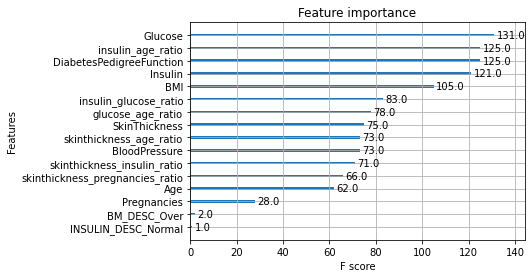

In [55]:
plot_importance(model3)